# Getting more (o less) data
In an ideal world we would have the same number of observations for each variable, sampled at the same frequency, but as we saw on the last section this is not the case. Some variables may be sampled daily while other weekly, monthly or even irregularly. 

We could try  to fix this by either  
- Reducing the sampling frequency by mean of **downsampling**
- Increase the sampling frequency by means of **interpolation**  


## Resampling
:::{card} Exercise 1
Read the documentation for  [`.resample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

Consider one of the temperature timeseries (eg. one of the temperature column in `Data/Time_series_Data.txt`), plot the original data (daily observations) with the data resampled at 3 days, 5 days, a week and a month.


 ```{admonition} Tips/Help
:class: tip, dropdown

Remember that `.resample()` just groups the data into bin and a  secondary method is needed to compute the resampled values, the simplest option is to use `resample().mean()`, but we can pass other potentially useful methods such as `.max()`,`std()`, `sum()`, etc.

```
:::

In [1]:
from funciones import*
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
from importlib import reload

Data=pd.read_csv("../../Data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
#file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/develop_1/data/Time_series_DATA.txt')
#Data=pd.read_csv(file3,skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")


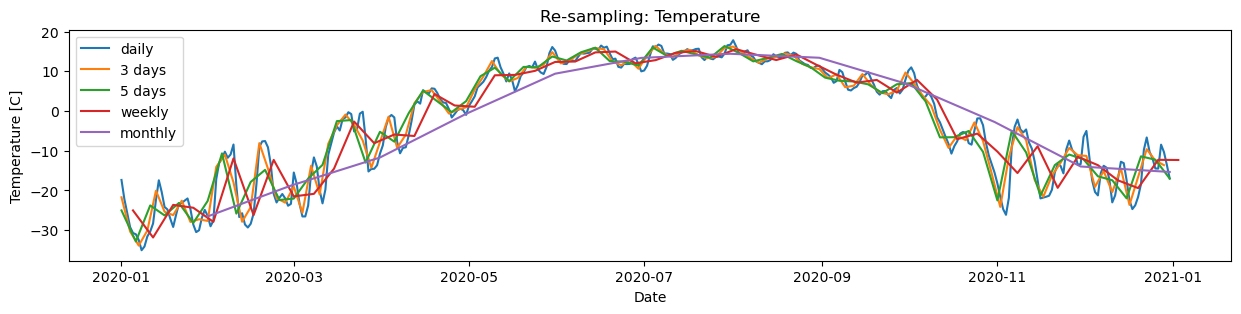

In [2]:
Temperature=Data['Regional: Air temperature [C]'] 
Temperature= Temperature[(Temperature.index.year >= 2020) & (Temperature.index.year < 2021)]
Temp_w3=Temperature.resample('3D').mean()
Temp_w5=Temperature.resample('5D').mean()
Temp_w7=Temperature.resample('W').mean()
Temp_w30=Temperature.resample('ME').mean()

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Temperature')
plt.plot(Temperature, label='daily')
plt.plot(Temp_w3,label='3 days')
plt.plot(Temp_w5,label='5 days')
plt.plot(Temp_w7,label='weekly')
plt.plot(Temp_w30,label='monthly')
plt.ylabel("Temperature [C]")
plt.xlabel("Date")
plt.legend()
plt.show()


::: {card} Exercise 2
Down-sample the rainfall observations using the `.sum()` to every three and five days
:::

> compare this to declustering in EVA ??

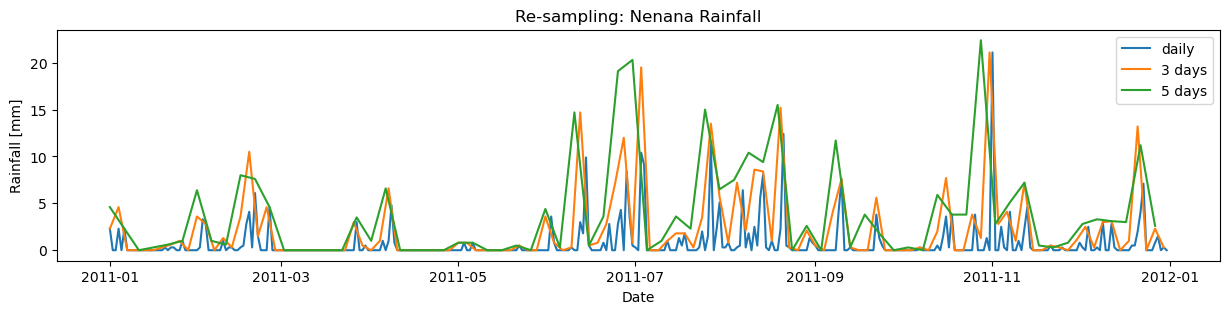

In [3]:
Rain=Data['Nenana: Rainfall [mm]']
         
Rain=Rain[(Rain.index.year >= 2011) & (Rain.index.year < 2012)]

Rain_d3=Rain.resample('3D').sum()
Rain_d5=Rain.resample('5D').sum()

fig, axs = plt.subplots(figsize=(15, 3))
plt.title('Re-sampling: Nenana Rainfall')
plt.plot(Rain, label='daily')
plt.plot(Rain_d3,label='3 days')
plt.plot(Rain_d5,label='5 days')
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
plt.legend()
plt.show()

## Interpolating
Interpolation in `Pandas` can be easily accomplished using the method  [.`interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html), which internally uses [`scipy.interpolate`](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate). Unlike the pure `scipy` implementation  the number of point to be interpolated  and the location/spacing is determined by the index of the `DataFrame/Series`.


The following figure is the result of directly applying the method `.interpolate()` to `Data['IceThickness [cm]']`.



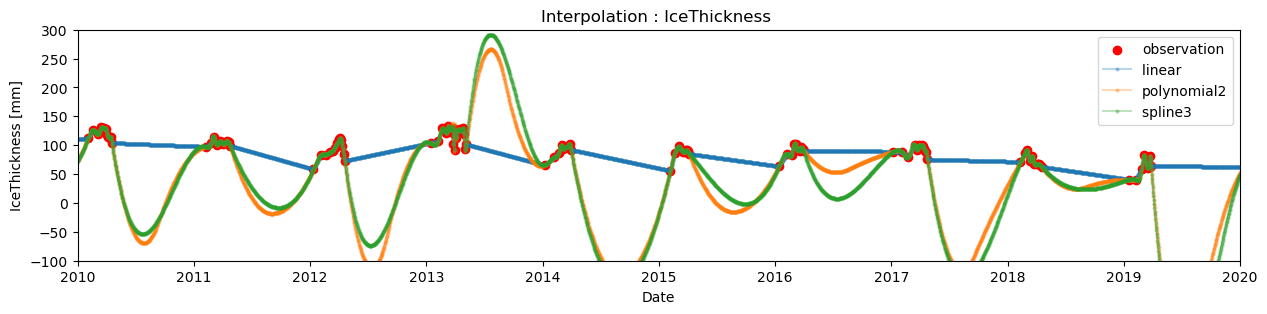

In [4]:
poly_order=2 # order of polynomic interpolatio

ICE_linear=Data['IceThickness [cm]'].interpolate(method='linear')
ICE_poly=Data['IceThickness [cm]'].interpolate(method='polynomial',order=poly_order)
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)


plt.figure(figsize=(15, 3))
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_linear.index,ICE_linear, label='linear ',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_poly, label=f'polynomial{poly_order}',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_spline.index,ICE_spline, label='spline3 ',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.ylim([-100,300])
plt.xlim(pd.to_datetime(['2010','2020'])) #
plt.xlabel("Date")
plt.legend()
plt.show()

You may notice that if we interpolate  `IceThickness` as-it-is,  will encounter a few problems.

1. We don't have observation during the summer (as there is no ice to be measured) the interpolation uses the last ice measurement from the previous year and th first measure from the current year to estimate the icethickness during the summer. This problem can be easily solved if we assign icethicknnes equal to zero for the summer months.

2. The polynomial and spline interpolation  result in negative values of ice thickness, which is not possible


::::{card} Ex 4 
Use indexing to assign  `IceThickness`=0  to the observations  made during the summer, and use [`.clip()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) to get rid of the negative values


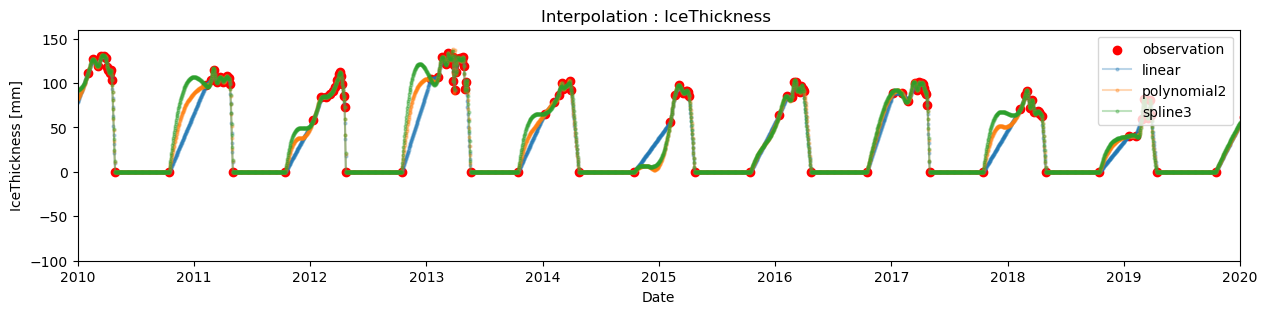

In [8]:
# fixing Problem 1

#there are multiple ways to do this a very simple and pragmatic way using only indexing is presented, using groupby()/.apply() we could get a more accurate interpolation
# similary we could have use masks using the temperature to determine the range of dates where we know that the thickness is zero  
date = pd.Timestamp('2024-10-15') 
oct_1 = date.dayofyear 
Data.loc[(Data.index.dayofyear == oct_1), 'IceThickness [cm]'] = 0
Data.loc[(Data['Days until break up'] == 0), 'IceThickness [cm]'] = 0


ICE_linear=Data['IceThickness [cm]'].interpolate(method='linear')
ICE_poly=Data['IceThickness [cm]'].interpolate(method='polynomial',order=poly_order)
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)


#Fixig Problem 2
ICE_poly = ICE_poly.clip(lower=0)
ICE_spline = ICE_spline.clip(lower=0)


plt.figure(figsize=(15, 3))
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_linear, label='linear',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_poly, label=f'polynomial{poly_order}',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_spline, label='spline3',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.ylim([-100,160])
plt.xlim(pd.to_datetime(['2010','2020']))
plt.xlabel("Date")
plt.legend()
plt.show()

In some circumstances sharp transitions in the data causes  spline interpolation to overshoot (> explain why or for theory in class???), or to present unusual oscillation (for example the interpolated data between oct-1 and the next observation present undesired oscillation). 

This phenomena can be fixed by using  'monotones splines'   by being only one time differentiable( if we mention this we kinda assume that they know how a spline is constructed)
In particular `pandas` ( through scipy ) has two methods [`pchip`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.pchip_interpolate.html) and [`akima`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Akima1DInterpolator.html) 

:::{card}ex
Compare the cubic spline interpolation with the `akima` and `pchip` interpolation

:::

> mention smth about boudnary condition in splines? higher dimensions? etc.  in interp there is a lot to mention but this guide is amazing and it might be redundant
(https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html) 


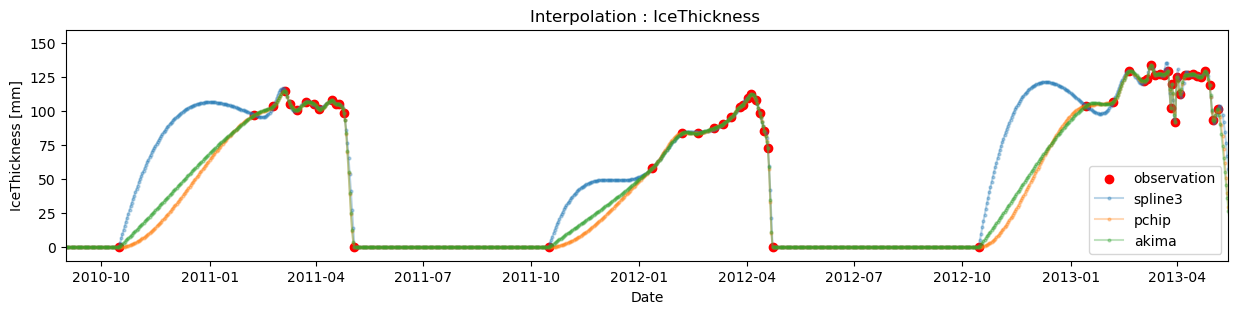

In [16]:
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)
ICE_pchip=Data['IceThickness [cm]'].interpolate(method='pchip')
ICE_akima=Data['IceThickness [cm]'].interpolate(method='akima')

ICE_spline = ICE_spline.clip(lower=0)
ICE_pchip = ICE_pchip.clip(lower=0)
ICE_akima = ICE_akima.clip(lower=0)

plt.figure(figsize=(15, 3))
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_spline, label='spline3',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_pchip, label='pchip',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_akima, label='akima',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.xlim(pd.to_datetime(['2010/09/01','2013/05/15']))
plt.ylim([-10,160])
plt.xlabel("Date")
plt.legend()
plt.show()

[Scipy](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html) has a great guide explaining the difference between the inteproaltion methods, higher order interpolations, and more advanced method etc. 